# Forecasting COVID-Affected Data  
This notebook showcases some scalecast techniques that can be used to forecast on series heavily affected by the COVID-19 pandemic. Special thanks to Zohoor Nezhad Halafi for helping with this notebook! Connect with her on [LinkedIn](https://www.linkedin.com/in/zohoor-nezhad-halafi/).

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.AnomalyDetector import AnomalyDetector
from scalecast.ChangepointDetector import ChangepointDetector
from scalecast.util import plot_reduction_errors, break_mv_forecaster, metrics
from scalecast import GridGenerator
from scalecast.multiseries import export_model_summaries
from scalecast.auxmodels import mlp_stack, auto_arima
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import pickle

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
GridGenerator.get_example_grids()

In [3]:
airline_series = ['Hou-Dom','IAH-DOM','IAH-Int']
fcst_horizon = 4

data = {
    l:pd.read_csv(
        os.path.join('data',l+'.csv')
    ) for l in airline_series
}

fdict = {
    l:Forecaster(
        y=df['PASSENGERS'],
        current_dates=df['Date'],
        future_dates=fcst_horizon,
    ) for l,df in data.items()
}

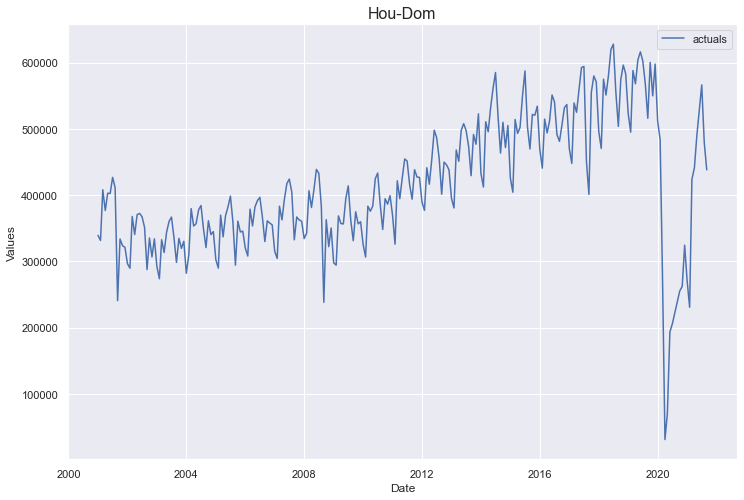

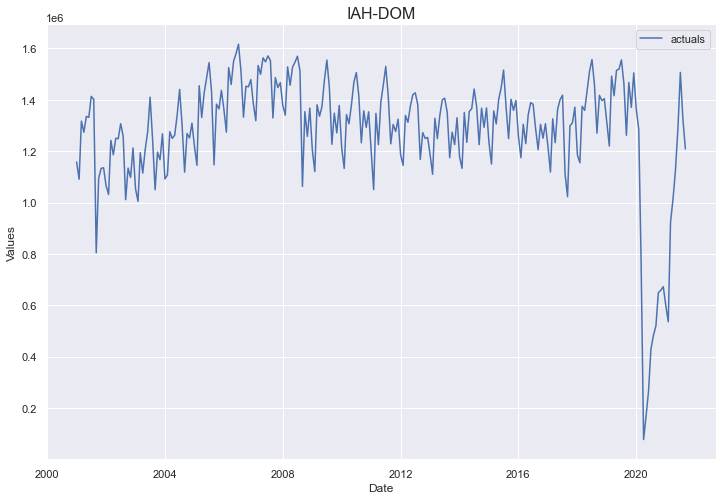

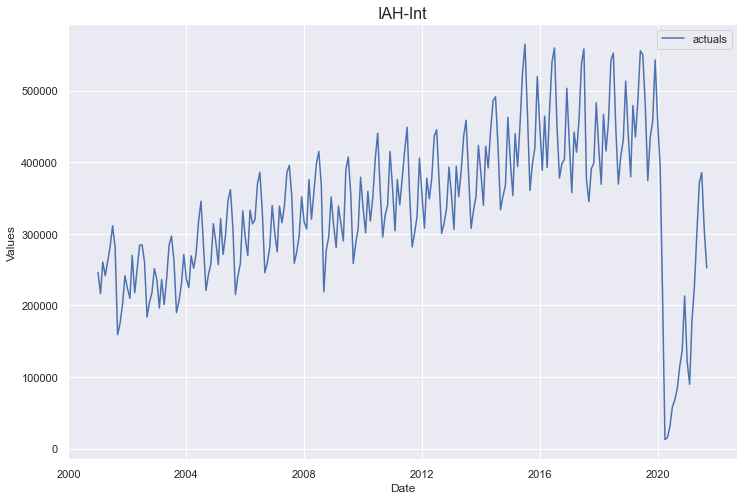

In [4]:
for l, f in fdict.items():
    f.plot()
    plt.title(l,size=16)
    plt.show()

## Add Anomalies to Model

scanning from obs 36 to obs 72
scanning from obs 72 to obs 108
scanning from obs 108 to obs 144
scanning from obs 144 to obs 180
scanning from obs 180 to obs 216
scanning from obs 216 to obs 252


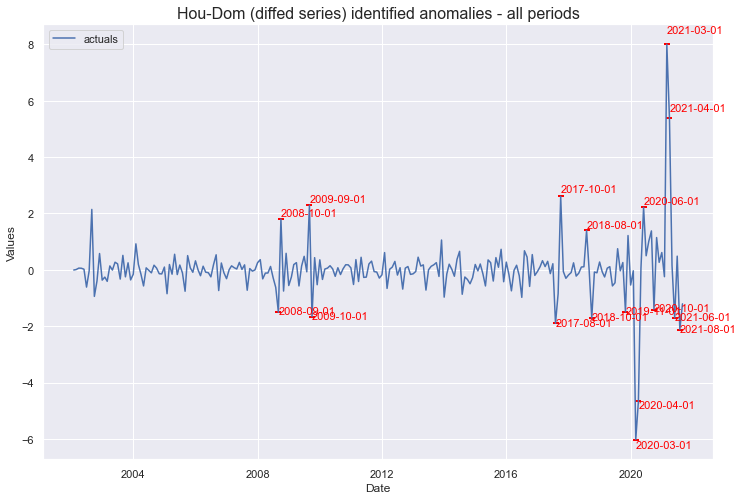

scanning from obs 36 to obs 72
scanning from obs 72 to obs 108
scanning from obs 108 to obs 144
scanning from obs 144 to obs 180
scanning from obs 180 to obs 216
scanning from obs 216 to obs 252


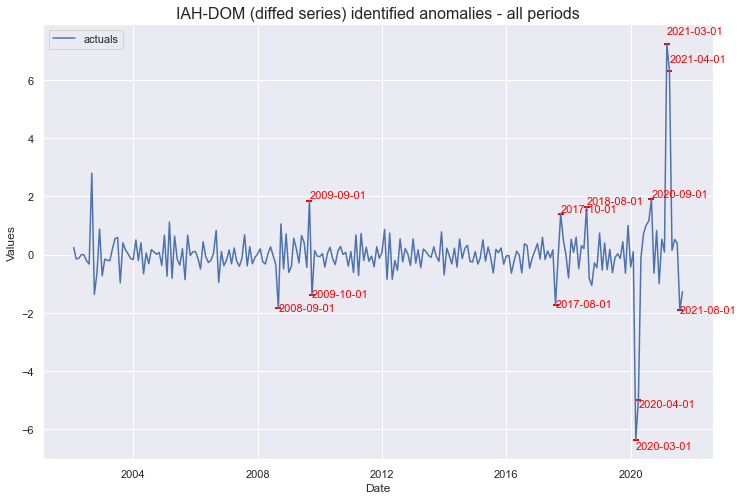

scanning from obs 36 to obs 72
scanning from obs 72 to obs 108
scanning from obs 108 to obs 144
scanning from obs 144 to obs 180
scanning from obs 180 to obs 216
scanning from obs 216 to obs 252


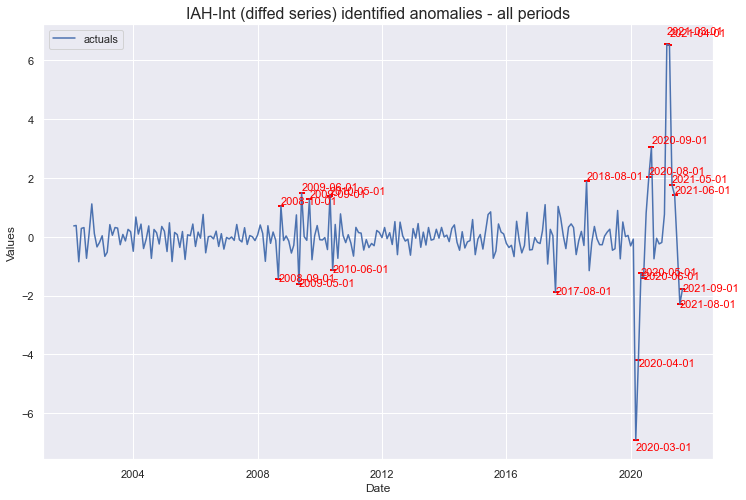

In [5]:
# scan on whole dataset to compare
for l, f in fdict.items():
    tr = SeriesTransformer(f)
    tr.DiffTransform(1)
    tr.DiffTransform(12)
    f2 = tr.ScaleTransform()
    ad = AnomalyDetector(f2)
    ad.MonteCarloDetect_sliding(36,36)
    ad.plot_anom()
    plt.title(f'{l} (diffed series) identified anomalies - all periods',size=16)
    plt.show()

- Sept 11 2001
- Recession sept 2008
- Hurricane Harvey August 2017

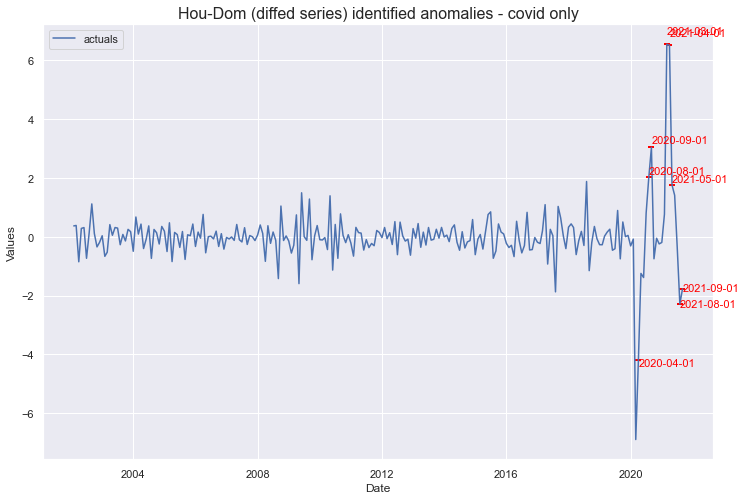

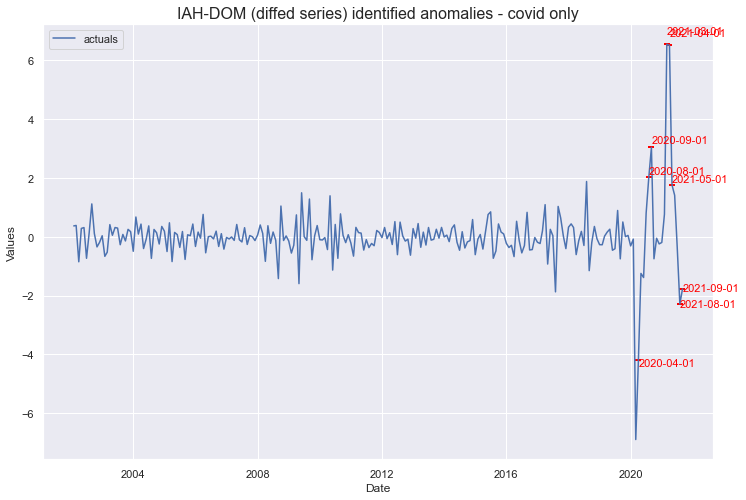

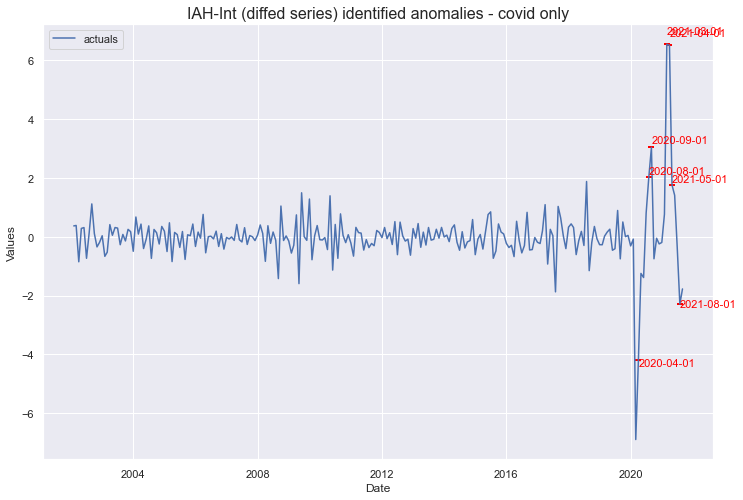

In [6]:
# scan over only covid periods
for l, f in fdict.items():
    ad.MonteCarloDetect(start_at='2020-04-01',stop_at='2021-09-01')
    ad.plot_anom()
    plt.title(f'{l} (diffed series) identified anomalies - covid only',size=16)
    plt.show()
    f = ad.WriteAnomtoXvars(f=f,drop_first=True)
    f.add_other_regressor(start = '2001-09-01', end='2001-09-01', called='2001')
    f.add_other_regressor(start = '2008-09-01', end='2008-09-01', called='Great Recession')
    f.add_other_regressor(start = '2017-08-01', end='2017-08-01', called='Harvey')
    fdict[l] = f

## Add Changepoints to Model

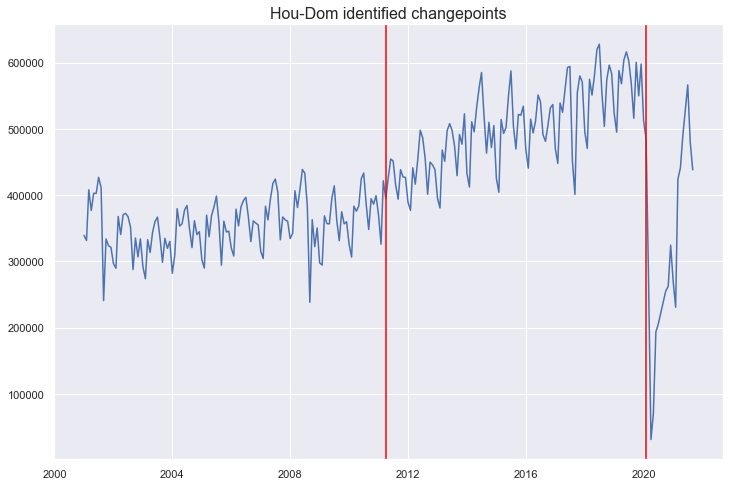

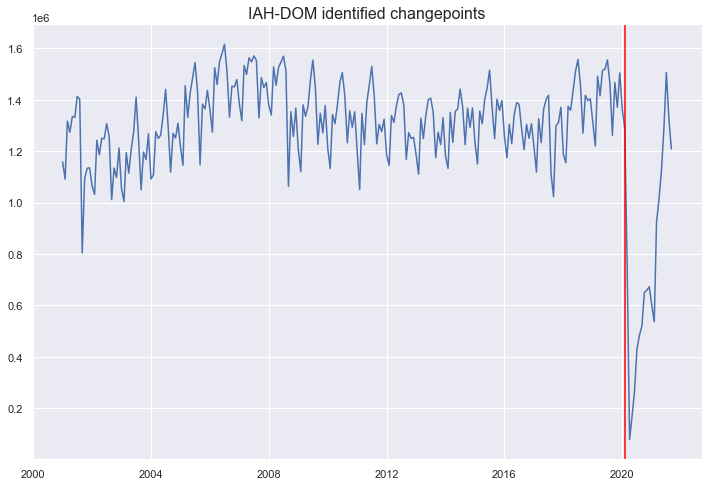

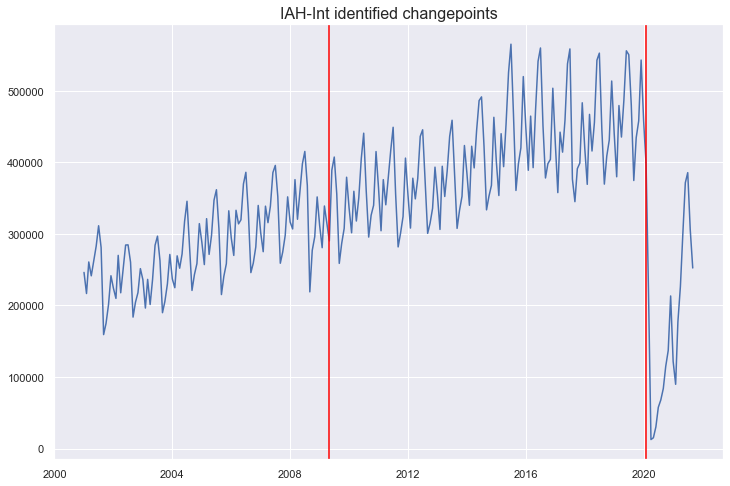

In [7]:
for l, f in fdict.items():
    cd = ChangepointDetector(f)
    cd.DetectCPCUSUM()
    cd.plot()
    plt.title(f'{l} identified changepoints',size=16)
    plt.show()
    f = cd.WriteCPtoXvars()
    fdict[l] = f

## Choose Xvars

In [8]:
regressors = pd.read_csv('data/Regressors.csv',parse_dates=['Date'],index_col=0)
for dt in f.future_dates:
    regressors.loc[dt] = [0]*regressors.shape[1]
    
for c in regressors:
    series = regressors[c]
    if adfuller(series)[1] >= 0.01:
        regressors[c] = regressors[c].diff()
regressors = regressors.fillna(0) # just for now
regressors.head()

Number of available seats Domestic and international level  \
Date                                                                     
2001-01-01                                                0.0            
2001-02-01                                         -7491574.0            
2001-03-01                                          8507261.0            
2001-04-01                                         -1273374.0            
2001-05-01                                          2815795.0            

            Number of domestic flights  Number of International  flights  \
Date                                                                       
2001-01-01                         0.0                               0.0   
2001-02-01                         0.0                               0.0   
2001-03-01                         0.0                               0.0   
2001-04-01                         0.0                               0.0   
2001-05-01                         0.0                               0.0   

            Revenue Passenger-miles/Domestic  \
Date                                           
2001-01-01                               0.0   
2001-02-01                               0.0   
2001-03-01                               0.0   
2001-04-01                               0.0   
2001-05-01                               0.0   

            Revenue Passenger-miles/International  TSI/Passengers  \
Date                                                                
2001-01-01                                    0.0             0.0   
2001-02-01                                    0.0             0.0   
2001-03-01                                    0.0             0.5   
2001-04-01                                    0.0             0.6   
2001-05-01                                    0.0             0.5   

            TSI/Freight  Trade, Transportation, and Utilities  \
Date                                                            
2001-01-01          0.0                                  0.00   
2001-02-01         -0.1                                  0.51   
2001-03-01          0.2                                 -0.12   
2001-04-01         -1.5                                 -0.23   
2001-05-01          1.5                                  0.57   

            All employees Information  Employees In financial activities  ...  \
Date                                                                      ...   
2001-01-01                       0.00                               0.00  ...   
2001-02-01                       0.11                               0.10  ...   
2001-03-01                      -0.12                               0.13  ...   
2001-04-01                      -0.12                              -0.05  ...   
2001-05-01                      -0.58                              -0.01  ...   

            Employees in Leisure and Hospitality  \
Date                                               
2001-01-01                                  0.00   
2001-02-01                                  0.57   
2001-03-01                                  0.38   
2001-04-01                                 -0.18   
2001-05-01                                  0.18   

            All Employees,Education and Health Services  \
Date                                                      
2001-01-01                                         0.00   
2001-02-01                                         0.81   
2001-03-01                                         0.60   
2001-04-01                                         0.72   
2001-05-01                                         1.61   

            All Employee,Mining and Logging: Oil and Gas Extraction  \
Date                                                                  
2001-01-01                                               0.00         
2001-02-01                                               0.36         
2001-03-01                                          

## Variable Reduction

reducing Hou-Dom


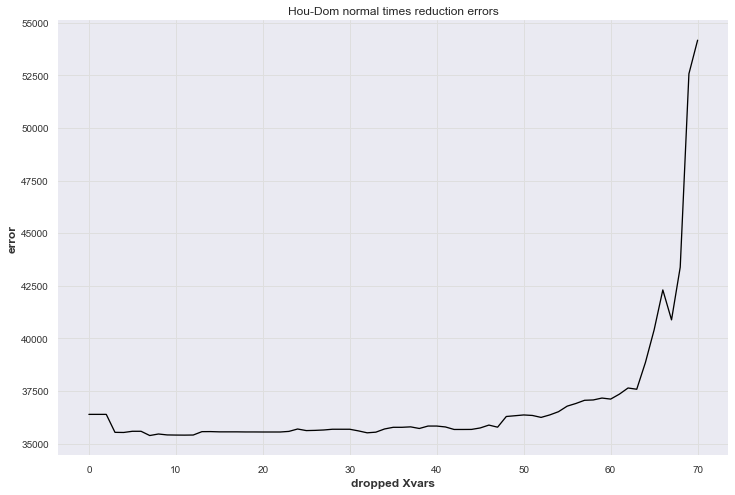

reducing IAH-DOM


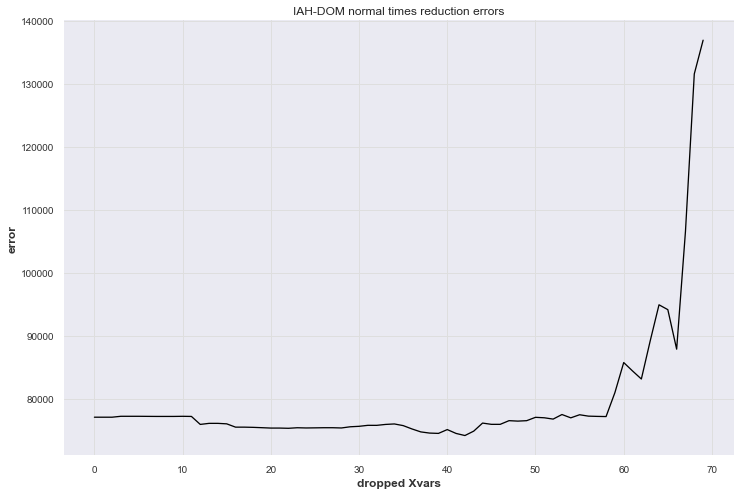

reducing IAH-Int


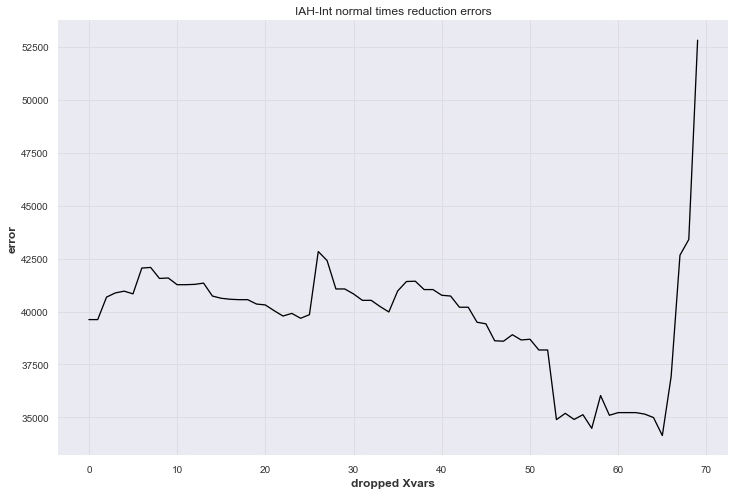

In [9]:
dropped = pd.DataFrame(columns=fdict.keys())

# first to get regressors for regular times
for l, f in fdict.items():
    print(f'reducing {l}')
    f2 = f.deepcopy()
    f2.add_ar_terms(36)
    f.add_seasonal_regressors(
        'month',
        raw=False,
        sincos=True
    )
    f2.add_time_trend()
    f2.diff()
    f2.ingest_Xvars_df(
        regressors.reset_index(),
        date_col='Date',
    )
    f2.reduce_Xvars(
        method='pfi',
        estimator='elasticnet',
        cross_validate=True,
        cvkwargs={'k':3},
        dynamic_tuning=fcst_horizon, # optimize on fcst_horizon worth of predictions
        overwrite=False,
    )
    for x in f2.pfi_dropped_vars:
        dropped.loc[x,l] = 1
    for x in f2.reduced_Xvars:
        dropped.loc[x,l] = 0
        
    plot_reduction_errors(f2)
    plt.title(f'{l} normal times reduction errors',size=12)
    plt.show()

#### Which variables were dropped most?

In [10]:
dropped = dropped.fillna(0).drop('total times dropped',axis=1,errors='ignore')
dropped['total times dropped'] = dropped.sum(axis=1)
dropped.sort_values(['total times dropped'],ascending=False).head(25)

Hou-Dom  IAH-DOM  IAH-Int  \
2001                                               1        1        1   
PCE on Recreational activities                     1        1        1   
AR16                                               1        1        1   
AR11                                               1        1        1   
Anomaly_2021-05-01                                 1        1        1   
Unemployement Rate in Houston Area                 1        1        1   
AR33                                               0        1        1   
AR10                                               0        1        1   
AR5                                                0        1        1   
Harvey                                             0        1        1   
WTO Oil Price                                      0        1        1   
AR13                                               0        1        1   
AR15                                               0        1        1   
AR21                                               0        1        1   
TSI/Freight                                        0        1        1   
Anomaly_2021-09-01                                 1        1        0   
Anomaly_2021-03-01                                 0        1        1   
AR3                                                0        1        1   
All Employees,Education and Health Services        0        1        1   
Employees In financial activities                  0        1        1   
AR34                                               0        1        1   
AR2                                                0        1        1   
AR22                                               0        1        1   
AR27                                               0        1        1   
Anomaly_2020-08-01                                 0        1        1   

                                             total times dropped  
2001                                                           3  
PCE on Recreational activities                                 3  
AR16                                                           3  
AR11                                                           3  
Anomaly_2021-05-01                                             3  
Unemployement Rate in Houston Area                             3  
AR33                                                           2  
AR10                                                           2  
AR5                                                            2  
Harvey                                                         2  
WTO Oil Price                                                  2  
AR13                                                           2  
AR15                                                           2  
AR21                                                           2  
TSI/Freight                                                    2  
Anomaly_2021-09-01                                             2  
Anomaly_2021-03-01                                             2  
AR3                                                            2  
All Employees,Education and Health Services                    2  
Employees In financial activities                              2  
AR34                                                           2  
AR2                                                            2  
AR22                                                           2  
AR27                                                           2  
Anomaly_2020-08-01                                             2

#### Which variables were dropped least?

In [11]:
dropped.sort_values(['total times dropped']).head(40)

Hou-Dom  IAH-DOM  IAH-Int  \
AR36                                                      0        0        0   
Revenue Passenger-miles/Domestic                          0        0        0   
AR18                                                      0        0        0   
Number of domestic flights                                0        0        0   
Number of International  flights                          0        0        0   
cp2                                                       0        0        1   
AR17                                                      0        0        1   
All employees Information                                 0        0        1   
Employees in Other Services                               0        0        1   
Employees in Leisure and Hospitality                      0        0        1   
Anomaly_2020-04-01                                        0        0        1   
PCE on Durable goods(Billions of Dollars, Month...        0        0        1   
AR25                                                      0        0        1   
AR31                                                      0        0        1   
AR6                                                       0        0        1   
Trade, Transportation, and Utilities                      0        0        1   
AR29                                                      0        0        1   
AR24                                                      0        0        1   
AR26                                                      0        0        1   
AR19                                                      0        0        1   
Revenue Passenger-miles/International                     0        0        1   
Recession                                                 0        0        1   
AR14                                                      0        0        1   
Texas Business CyclesIndex                                0        0        1   
AR12                                                      0        0        1   
AR1                                                       0        0        1   
TSI/Passengers                                            0        0        1   
AR30                                                      0        0        1   
Number of available seats Domestic and internat...        0        0        1   
Anomaly_2021-03-01                                        0        1        1   
AR22                                                      0        1        1   
All Employees,Education and Health Services               0        1        1   
AR2                                                       0        1        1   
Employees In financial activities                         0        1        1   
TSI/Freight                                               0        1        1   
AR34                                                      0        1        1   
Anomaly_2020-08-01                                        0        1        1   
AR21                                                      0        1        1   
Anomaly_2021-09-01                                        1        1        0   
AR9                                                       0        1        1   

                                                    total times dropped  
AR36                                                                  0  
Revenue Passenger-miles/Domestic                                      0  
AR18                                                                  0  
Number of domestic flights                                            0  
Number of International  flights                                      0  
cp2                                                                   1  
AR17                                                                  1  
All employees Information                                             1  
Employees in Other Services                                     

#### What about AR terms?

In [12]:
ar_dropped = dropped.reset_index()
ar_dropped = ar_dropped.loc[ar_dropped['index'].str.contains('AR')]
ar_dropped['ar'] = ar_dropped['index'].apply(lambda x: int(x[2:]))
ar_dropped.sort_values('ar')

index  Hou-Dom  IAH-DOM  IAH-Int  total times dropped  ar
53   AR1        0        0        1                    1   1
60   AR2        0        1        1                    2   2
25   AR3        0        1        1                    2   3
9    AR4        0        1        1                    2   4
28   AR5        0        1        1                    2   5
37   AR6        0        0        1                    1   6
19   AR7        0        1        1                    2   7
24   AR8        0        1        1                    2   8
7    AR9        0        1        1                    2   9
27  AR10        0        1        1                    2  10
4   AR11        1        1        1                    3  11
66  AR12        0        0        1                    1  12
31  AR13        0        1        1                    2  13
58  AR14        0        0        1                    1  14
32  AR15        0        1        1                    2  15
3   AR16        1        1        1                    3  16
49  AR17        0        0        1                    1  17
51  AR18        0        0        0                    0  18
56  AR19        0        0        1                    1  19
13  AR20        0        1        1                    2  20
33  AR21        0        1        1                    2  21
61  AR22        0        1        1                    2  22
12  AR23        0        1        1                    2  23
70  AR24        0        0        1                    1  24
40  AR25        0        0        1                    1  25
55  AR26        0        0        1                    1  26
26  AR27        0        1        1                    2  27
10  AR28        0        1        1                    2  28
36  AR29        0        0        1                    1  29
62  AR30        0        0        1                    1  30
38  AR31        0        0        1                    1  31
14  AR32        0        1        1                    2  32
34  AR33        0        1        1                    2  33
52  AR34        0        1        1                    2  34
23  AR35        0        1        1                    2  35
69  AR36        0        0        0                    0  36

### Subjectively make selections

In [13]:
final_Xvars_selected = [
    x for x in dropped.loc[dropped['total times dropped'] == 0].index if x in regressors
]

final_anom_selected = [
    x for x in dropped.loc[dropped['total times dropped'] <= 1].index if x.startswith('Anomaly') or x in ('Harvey','2001','Great Recession') or x.startswith('cp')
]

lags = {
    'Hou-Dom':[1,12,24,36],
    'IAH-DOM':[1,12,24,36],
    'IAH-Int':[1,12,24,36],
}

In [14]:
for l, f in fdict.items():
    f.drop_Xvars(*[x for x in f.get_regressor_names() if x not in final_anom_selected])
    f.add_seasonal_regressors('month',raw=False,sincos=True)
    f.diff()

## Multivariate Forecasting

In [15]:
mvfdict = fdict.copy()

for x in final_Xvars_selected:
    if x in regressors:
        mvfdict[x] = Forecaster(
            y=regressors[x].values[:-4],
            current_dates = regressors.index.values[:-4],
        )
        lags[x] = [1]
        
for l, f in fdict.items():
    f.drop_Xvars(*[x for x in f.get_regressor_names() if x in regressors])

mvf = MVForecaster(*mvfdict.values(),names=mvfdict.keys())
mvf.add_optimizer_func(lambda x: x[0]*(1/3) + x[1]*(1/3) + x[2]*(1/3),'weighted') # first three series only get weight
mvf.set_optimize_on('weighted')
mvf.set_test_length(fcst_horizon)
mvf.set_validation_metric('mae')
mvf.set_validation_length(36)
mvf

MVForecaster(
    DateStartActuals=2001-01-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=249
    N_series=6
    SeriesNames=['Hou-Dom', 'IAH-DOM', 'IAH-Int', 'Number of International  flights', 'Number of domestic flights', 'Revenue Passenger-miles/Domestic']
    ForecastLength=4
    Xvars=['Anomaly_2020-04-01', 'cp2', 'monthsin', 'monthcos']
    TestLength=4
    ValidationLength=36
    ValidationMetric=mae
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=weighted
)

In [16]:
elasticnet = {
    'alpha':[i/10 for i in range(1,21)],
    'l1_ratio':[0,0.25,0.5,0.75,1],
    'normalizer':['scale','minmax',None],
    'lags':[lags],
}
knn = {
    'n_neighbors':range(2,76),
    'lags':[lags],
}

lightgbm = {
    'n_estimators':[150,200,250],
    'boosting_type':['gbdt','dart','goss'],
    'max_depth':[1,2,3],
    'learning_rate':[0.001,0.01,0.1],
    'lags':[lags],
}
mlp = {
    'activation':['relu','tanh'],
    'hidden_layer_sizes':[(25,),(25,25,)],
    'solver':['lbfgs','adam'],
    'normalizer':['minmax','scale'],
    'lags':[lags],
}
mlr = {
    'normalizer':['scale','minmax',None],
    'lags':[lags],
}
sgd={
    'penalty':['l2','l1','elasticnet'],
    'l1_ratio':[0,0.15,0.5,0.85,1],
    'learning_rate':['invscaling','constant','optimal','adaptive'],
    'lags':[lags],
}
svr={
    'kernel':['linear'],
    'C':[.5,1,2,3],
    'epsilon':[0.01,0.1,0.5],
    'lags':[lags],
}
xgboost = {
    'n_estimators':[150,200,250],
    'scale_pos_weight':[5,10],
    'learning_rate':[0.1,0.2],
    'gamma':[0,3,5],
    'subsample':[0.8,0.9],
    'lags':[lags],
}

In [17]:
models = (
    'knn',
    'mlr',
    'elasticnet',
    'sgd',
    'xgboost',
    'lightgbm',
    'mlp',
)

print('begining models cross validated')
for m in tqdm(models):
    mvf.set_estimator(m)
    mvf.ingest_grid(globals()[m])
    mvf.limit_grid_size(10)
    mvf.cross_validate(k=3,dynamic_tuning=fcst_horizon)
    mvf.auto_forecast(call_me=f'{m}_cv_mv')

print('begining models tuned')
for m in tqdm(models):
    mvf.set_estimator(m)
    mvf.ingest_grid(globals()[m])
    mvf.limit_grid_size(10)
    mvf.tune(dynamic_tuning=fcst_horizon)
    mvf.auto_forecast(call_me=f'{m}_tune_mv')

begining models cross validated


  0%|          | 0/7 [00:00<?, ?it/s]

begining models tuned


  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results = mvf.export('model_summaries')
results_sub = results.loc[results['Series'].isin(airline_series)]
results_sub[['Series','ModelNickname','LevelTestSetR2','LevelTestSetMAPE']]

Series       ModelNickname  LevelTestSetR2  LevelTestSetMAPE
0   Hou-Dom  elasticnet_tune_mv       -0.008851          0.092853
1   Hou-Dom           knn_cv_mv       -0.122960          0.100203
2   Hou-Dom           mlr_cv_mv       -4.865199          0.209266
3   Hou-Dom    elasticnet_cv_mv       -0.046781          0.090712
4   Hou-Dom           sgd_cv_mv        0.044149          0.086127
5   Hou-Dom       xgboost_cv_mv       -1.806345          0.130049
6   Hou-Dom      lightgbm_cv_mv       -0.020278          0.087836
7   Hou-Dom           mlp_cv_mv       -0.082069          0.087113
8   Hou-Dom         knn_tune_mv       -0.731346          0.106951
9   Hou-Dom         mlr_tune_mv       -4.865199          0.209266
10  Hou-Dom         sgd_tune_mv        0.069918          0.086680
11  Hou-Dom     xgboost_tune_mv       -1.687364          0.129505
12  Hou-Dom    lightgbm_tune_mv        0.106759          0.086545
13  Hou-Dom         mlp_tune_mv        0.140452          0.080000
14  IAH-DOM  elasticnet_tune_mv       -2.675066          0.130365
15  IAH-DOM           knn_cv_mv       -1.521107          0.102719
16  IAH-DOM           mlr_cv_mv       -0.700337          0.065628
17  IAH-DOM    elasticnet_cv_mv       -3.282911          0.143407
18  IAH-DOM           sgd_cv_mv       -3.305075          0.144816
19  IAH-DOM       xgboost_cv_mv       -1.703854          0.112821
20  IAH-DOM      lightgbm_cv_mv       -3.602143          0.150592
21  IAH-DOM           mlp_cv_mv       -3.669990          0.150982
22  IAH-DOM         knn_tune_mv       -0.765313          0.077754
23  IAH-DOM         mlr_tune_mv       -0.700337          0.065628
24  IAH-DOM         sgd_tune_mv       -3.141806          0.141990
25  IAH-DOM     xgboost_tune_mv       -2.161605          0.126577
26  IAH-DOM    lightgbm_tune_mv       -2.480593          0.125745
27  IAH-DOM         mlp_tune_mv       -2.759960          0.128641
28  IAH-Int  elasticnet_tune_mv       -0.019007          0.153717
29  IAH-Int           knn_cv_mv       -0.411933          0.196223
30  IAH-Int           mlr_cv_mv       -2.984908          0.283815
31  IAH-Int    elasticnet_cv_mv       -0.175874          0.148786
32  IAH-Int           sgd_cv_mv       -0.637143          0.207411
33  IAH-Int       xgboost_cv_mv       -1.073559          0.225976
34  IAH-Int      lightgbm_cv_mv       -0.132948          0.156983
35  IAH-Int           mlp_cv_mv       -0.302144          0.156178
36  IAH-Int         knn_tune_mv       -0.689363          0.192302
37  IAH-Int         mlr_tune_mv       -2.984908          0.283815
38  IAH-Int         sgd_tune_mv       -0.498934          0.200455
39  IAH-Int     xgboost_tune_mv       -0.300637          0.173677
40  IAH-Int    lightgbm_tune_mv       -0.715109          0.207723
41  IAH-Int         mlp_tune_mv       -0.430382          0.193184

In [19]:
models_to_stack = (
    'knn_cv_mv',
    'elasticnet_cv_mv',
    'xgboost_cv_mv',
    'lightgbm_cv_mv',
)
mlp_stack(
    mvf,
    model_nicknames = models_to_stack,
    call_me='stacking_mv',
)

In [20]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')
results = mvf.export('model_summaries')
results_sub = results.loc[results['Series'].isin(airline_series)]
results_sub[['Series','ModelNickname','LevelTestSetR2','LevelTestSetMAPE']]

Series       ModelNickname  LevelTestSetR2  LevelTestSetMAPE
0   Hou-Dom         stacking_mv        0.137636          0.062217
1   Hou-Dom           knn_cv_mv       -0.122960          0.100203
2   Hou-Dom           mlr_cv_mv       -4.865199          0.209266
3   Hou-Dom    elasticnet_cv_mv       -0.046781          0.090712
4   Hou-Dom           sgd_cv_mv        0.044149          0.086127
5   Hou-Dom       xgboost_cv_mv       -1.806345          0.130049
6   Hou-Dom      lightgbm_cv_mv       -0.020278          0.087836
7   Hou-Dom           mlp_cv_mv       -0.082069          0.087113
8   Hou-Dom         knn_tune_mv       -0.731346          0.106951
9   Hou-Dom         mlr_tune_mv       -4.865199          0.209266
10  Hou-Dom  elasticnet_tune_mv       -0.008851          0.092853
11  Hou-Dom         sgd_tune_mv        0.069918          0.086680
12  Hou-Dom     xgboost_tune_mv       -1.687364          0.129505
13  Hou-Dom    lightgbm_tune_mv        0.106759          0.086545
14  Hou-Dom         mlp_tune_mv        0.140452          0.080000
15  IAH-DOM         stacking_mv       -1.030366          0.097983
16  IAH-DOM           knn_cv_mv       -1.521107          0.102719
17  IAH-DOM           mlr_cv_mv       -0.700337          0.065628
18  IAH-DOM    elasticnet_cv_mv       -3.282911          0.143407
19  IAH-DOM           sgd_cv_mv       -3.305075          0.144816
20  IAH-DOM       xgboost_cv_mv       -1.703854          0.112821
21  IAH-DOM      lightgbm_cv_mv       -3.602143          0.150592
22  IAH-DOM           mlp_cv_mv       -3.669990          0.150982
23  IAH-DOM         knn_tune_mv       -0.765313          0.077754
24  IAH-DOM         mlr_tune_mv       -0.700337          0.065628
25  IAH-DOM  elasticnet_tune_mv       -2.675066          0.130365
26  IAH-DOM         sgd_tune_mv       -3.141806          0.141990
27  IAH-DOM     xgboost_tune_mv       -2.161605          0.126577
28  IAH-DOM    lightgbm_tune_mv       -2.480593          0.125745
29  IAH-DOM         mlp_tune_mv       -2.759960          0.128641
30  IAH-Int         stacking_mv        0.725500          0.062671
31  IAH-Int           knn_cv_mv       -0.411933          0.196223
32  IAH-Int           mlr_cv_mv       -2.984908          0.283815
33  IAH-Int    elasticnet_cv_mv       -0.175874          0.148786
34  IAH-Int           sgd_cv_mv       -0.637143          0.207411
35  IAH-Int       xgboost_cv_mv       -1.073559          0.225976
36  IAH-Int      lightgbm_cv_mv       -0.132948          0.156983
37  IAH-Int           mlp_cv_mv       -0.302144          0.156178
38  IAH-Int         knn_tune_mv       -0.689363          0.192302
39  IAH-Int         mlr_tune_mv       -2.984908          0.283815
40  IAH-Int  elasticnet_tune_mv       -0.019007          0.153717
41  IAH-Int         sgd_tune_mv       -0.498934          0.200455
42  IAH-Int     xgboost_tune_mv       -0.300637          0.173677
43  IAH-Int    lightgbm_tune_mv       -0.715109          0.207723
44  IAH-Int         mlp_tune_mv       -0.430382          0.193184

## Univariate Forecasting

In [21]:
f1, f2, f3 = break_mv_forecaster(mvf)[:3]
fdict[airline_series[0]] = f1
fdict[airline_series[1]] = f2
fdict[airline_series[2]] = f3

In [22]:
f1

Forecaster(
    DateStartActuals=2001-02-01T00:00:00.000000000
    DateEndActuals=2021-09-01T00:00:00.000000000
    Freq=MS
    N_actuals=248
    ForecastLength=4
    Xvars=['Anomaly_2020-04-01', 'cp2', 'monthsin', 'monthcos']
    Differenced=1
    TestLength=4
    ValidationLength=36
    ValidationMetric=rmse
    ForecastsEvaluated=['knn_cv_mv', 'mlr_cv_mv', 'elasticnet_cv_mv', 'sgd_cv_mv', 'xgboost_cv_mv', 'lightgbm_cv_mv', 'mlp_cv_mv', 'knn_tune_mv', 'mlr_tune_mv', 'elasticnet_tune_mv', 'sgd_tune_mv', 'xgboost_tune_mv', 'lightgbm_tune_mv', 'mlp_tune_mv', 'stacking_mv']
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [23]:
models = (
    'knn',
    'mlr',
    'elasticnet',
    'sgd',
    'xgboost',
    'lightgbm',
    'mlp',
    'hwes',
    'arima',
    'prophet',
    'silverkite',
    'theta',
)

for l, f in fdict.items():
    print(f'processing {l}')
    f.add_ar_terms(1)
    f.add_AR_terms((3,6))
    f.add_AR_terms((3,12))
    auto_arima(
        f,
        m=12,
        error_action='ignore',
    )
    f.manual_forecast(
        order=f.auto_arima_params['order'],
        seasonal_order=f.auto_arima_params['seasonal_order'],
        Xvars = 'all',
        call_me='auto_arima_anom',
    )
    f.tune_test_forecast(
        models,
        limit_grid_size=10,
        cross_validate=True,
        k=3,
        dynamic_tuning=fcst_horizon,
        suffix='_cv_uv',
    )
    f.tune_test_forecast(
        models,
        limit_grid_size=10,
        cross_validate=False,
        dynamic_tuning=fcst_horizon,
        suffix='_tune_uv',
    )

processing Hou-Dom
processing IAH-DOM
processing IAH-Int


In [24]:
results = export_model_summaries(
    fdict,
    determine_best_by='LevelTestSetMAPE',
)
results[
    [
        'Series',
        'ModelNickname',
        'LevelTestSetMAPE',
    ]
].sort_values(
    [
        'Series',
        'LevelTestSetMAPE',
    ]
).head(25)

Series       ModelNickname  LevelTestSetMAPE
0   Hou-Dom       prophet_cv_uv          0.024967
1   Hou-Dom       arima_tune_uv          0.031463
2   Hou-Dom         arima_cv_uv          0.031463
3   Hou-Dom        hwes_tune_uv          0.040938
4   Hou-Dom          hwes_cv_uv          0.040938
5   Hou-Dom     auto_arima_anom          0.041796
6   Hou-Dom     prophet_tune_uv          0.046722
7   Hou-Dom           sgd_cv_uv          0.054584
8   Hou-Dom         sgd_tune_uv          0.056646
9   Hou-Dom         stacking_mv          0.062217
10  Hou-Dom          auto_arima          0.071545
11  Hou-Dom         mlr_tune_uv          0.072219
12  Hou-Dom           mlr_cv_uv          0.072219
13  Hou-Dom    elasticnet_cv_uv          0.072386
14  Hou-Dom  elasticnet_tune_uv          0.073144
15  Hou-Dom           mlp_cv_uv          0.075766
16  Hou-Dom         mlp_tune_uv          0.079230
17  Hou-Dom         mlp_tune_mv          0.080000
18  Hou-Dom      lightgbm_cv_uv          0.084266
19  Hou-Dom           sgd_cv_mv          0.086127
20  Hou-Dom    lightgbm_tune_mv          0.086545
21  Hou-Dom         sgd_tune_mv          0.086680
22  Hou-Dom           mlp_cv_mv          0.087113
23  Hou-Dom    lightgbm_tune_uv          0.087297
24  Hou-Dom      lightgbm_cv_mv          0.087836

In [25]:
models_to_stack = (
    'knn_cv_uv',
    'sgd_cv_uv',
    'elasticnet_cv_uv',
    'xgboost_cv_uv',
)

for l, f in fdict.items():
    mlp_stack(
        f,
        model_nicknames=models_to_stack,
        call_me='stacking_uv'
    )

In [26]:
for l, f in fdict.items():
    # trains 120 total lstm models to get forecast intervals probabilistically
    f.set_estimator('rnn')
    f.proba_forecast(
        lags=48,
        layers_struct=[('LSTM',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
        epochs=8,
        random_seed=42,
        validation_split=0.2,
        call_me = 'lstm',
    )
    
    f.set_estimator('combo')
    f.manual_forecast(how='simple',call_me='avg')
    f.manual_forecast(how='weighted',determine_best_by='LevelTestSetMAPE',call_me='weighted')

Epoch 1/8
5/5 [==============================] - 4s 220ms/step - loss: 0.4620 - val_loss: 0.2296
Epoch 2/8
5/5 [==============================] - 0s 50ms/step - loss: 0.1978 - val_loss: 0.0809
Epoch 3/8
5/5 [==============================] - 0s 50ms/step - loss: 0.1269 - val_loss: 0.0839
Epoch 4/8
5/5 [==============================] - 0s 53ms/step - loss: 0.1066 - val_loss: 0.0730
Epoch 5/8
5/5 [==============================] - 0s 55ms/step - loss: 0.1078 - val_loss: 0.0715
Epoch 6/8
5/5 [==============================] - 0s 57ms/step - loss: 0.1027 - val_loss: 0.0679
Epoch 7/8
5/5 [==============================] - 0s 57ms/step - loss: 0.1011 - val_loss: 0.0684
Epoch 8/8
5/5 [==============================] - 0s 57ms/step - loss: 0.1015 - val_loss: 0.0667
Epoch 1/8
5/5 [==============================] - 3s 216ms/step - loss: 0.4601 - val_loss: 0.3736
Epoch 2/8
5/5 [==============================] - 0s 53ms/step - loss: 0.3318 - val_loss: 0.2527
Epoch 3/8
5/5 [=======================

In [27]:
results = export_model_summaries(fdict,determine_best_by='LevelTestSetMAPE')
results[['Series','ModelNickname','LevelTestSetMAPE']].sort_values(['Series','LevelTestSetMAPE']).head(25)

Series       ModelNickname  LevelTestSetMAPE
0   Hou-Dom       prophet_cv_uv          0.024967
1   Hou-Dom       arima_tune_uv          0.031463
2   Hou-Dom         arima_cv_uv          0.031463
3   Hou-Dom        hwes_tune_uv          0.040938
4   Hou-Dom          hwes_cv_uv          0.040938
5   Hou-Dom     auto_arima_anom          0.041796
6   Hou-Dom     prophet_tune_uv          0.046722
7   Hou-Dom           sgd_cv_uv          0.054584
8   Hou-Dom         sgd_tune_uv          0.056646
9   Hou-Dom         stacking_mv          0.062217
10  Hou-Dom          auto_arima          0.071545
11  Hou-Dom         mlr_tune_uv          0.072219
12  Hou-Dom           mlr_cv_uv          0.072219
13  Hou-Dom    elasticnet_cv_uv          0.072386
14  Hou-Dom            weighted          0.072712
15  Hou-Dom  elasticnet_tune_uv          0.073144
16  Hou-Dom           mlp_cv_uv          0.075766
17  Hou-Dom         mlp_tune_uv          0.079230
18  Hou-Dom         mlp_tune_mv          0.080000
19  Hou-Dom                 avg          0.081842
20  Hou-Dom      lightgbm_cv_uv          0.084266
21  Hou-Dom           sgd_cv_mv          0.086127
22  Hou-Dom    lightgbm_tune_mv          0.086545
23  Hou-Dom         sgd_tune_mv          0.086680
24  Hou-Dom           mlp_cv_mv          0.087113

In [28]:
test = pd.read_csv(
    'data/Future Passengers.csv',
    parse_dates=['DATE'],
    index_col=0,
)
test.head()

HOU-Int  Hou-Dom  IAH-DOM  IAH-Int
DATE                                          
2021-10-01    27153   498237  1375815   285498
2021-11-01    34242   495800  1356136   336156
2021-12-01    39101   477752  1331893   417561
2022-01-01    29084   387446  1036051   287998

## Export Results

In [29]:
final_results = results.copy()
for l, f in fdict.items():
    df = pd.DataFrame()
    fcsts = f.export('lvl_fcsts').set_index('DATE')
    for c in fcsts:
        df.loc[c,'FcstMAPE' + l] = metrics.mape(test[l],fcsts[c])
    df['Series'] = l
    final_results = final_results.merge(
        df.reset_index(),
        how='left',
        left_on=['ModelNickname','Series'],
        right_on=['index','Series'],
    )
final_results['FcstMAPE'] = final_results[
    [
        c for c in final_results if c.startswith('FcstMAPE')
    ]
].apply(
    lambda x: (
        x[0] 
        if not np.isnan(x[0]) 
        else x[1] if not np.isnan(x[1]) 
        else x[2] if not np.isnan(x[2]) 
        else x[3]
    ),
    axis=1,
)
final_results.drop(
    [
        c for c in final_results if (
            c.startswith('FcstMAPE') and c != 'FcstMAPE'
        ) or c.startswith('index')
    ],
    axis=1,
    inplace=True,
)
final_results['ObjectEstimator'] = final_results['ModelNickname'].apply(
    lambda x: 'MVForecaster' if '_mv' in x else 'Forecaster'
)
final_results['Used Anomalies'] = final_results['Xvars'].apply(
    lambda x: False if x is None else final_anom_selected[0] in x
)

In [30]:
final_results[['Series','ModelNickname','LevelTestSetMAPE','FcstMAPE']].sort_values(['Series','FcstMAPE']).head(10)

Series       ModelNickname  LevelTestSetMAPE  FcstMAPE
7   Hou-Dom           sgd_cv_uv          0.054584  0.027731
8   Hou-Dom         sgd_tune_uv          0.056646  0.034350
23  Hou-Dom         sgd_tune_mv          0.086680  0.049739
36  Hou-Dom         knn_tune_mv          0.106951  0.052050
21  Hou-Dom           sgd_cv_mv          0.086127  0.054210
15  Hou-Dom  elasticnet_tune_uv          0.073144  0.058379
0   Hou-Dom       prophet_cv_uv          0.024967  0.060044
6   Hou-Dom     prophet_tune_uv          0.046722  0.060630
25  Hou-Dom    lightgbm_tune_uv          0.087297  0.060856
14  Hou-Dom            weighted          0.072712  0.061285

In [31]:
final_results.to_csv('final_results.csv',index=False)

In [35]:
pd.pivot_table(
    final_results,
    index='Estimator',
    values='FcstMAPE',
    aggfunc=np.mean,
).sort_values('FcstMAPE')

FcstMAPE
Estimator           
sgd         0.059227
hwes        0.070423
combo       0.071353
prophet     0.076977
arima       0.078932
mlr         0.082993
lightgbm    0.086944
stacking    0.093409
silverkite  0.099222
knn         0.100048
mlp         0.108065
elasticnet  0.110694
rnn         0.124109
xgboost     0.126917
theta       0.153371

In [33]:
pd.pivot_table(
    final_results,
    index='ObjectEstimator',
    values='FcstMAPE',
    aggfunc=np.mean,
).sort_values('FcstMAPE')

FcstMAPE
ObjectEstimator          
Forecaster       0.091701
MVForecaster     0.101191

In [34]:
with open('fdict.pckl', 'wb') as fl:
    pickle.dump(fdict,fl)